In [19]:
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
import geopandas
from utilities.weatherFunctions import *
from utilities.geographicFunctions import *

# Using Baseline to calculate heatwaves using multiple definitions

There are two definitions of a heatwave that are more nuanced than the current definition used by the WMO. 

1. **Heat Index**: Heat index aka apparent temperature is based on work carried out by Robert G. Steadman in 1979 ("An Assessment of Sultriness, Parts I and II") where he discussed factors that would impact how hot a person would feel under certain conditions. It incorporates 21 parameters and assumptions: body mass (147.7 lbs), height (5'7"), actively walking (3.1 mph), clothing (pants and short sleeve shirt), heat tolerance, in the shade, etc. This formula became the "heat index". It is the traditional measurement of heat stress due to high temperatures and high humidity.
*Heat index is calculated for shady areas*

    The inputs to this are - temperature, relative humidity

    Equation:

    Heat Index = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH

    * T = ambient dry temperature (in Fahrenheit)
    * R = relative humidity (percentage)

2. **Wet Bulb Globe Temperature (WBGT)**: WBGT is an indicator of heat related stress on the human body at work (or play) in direct sunlight. It takes into account multiple atmospheric variables, including: temperature, humidity, wind speed, sun angle, and cloud cover.

    Equation:

    WBGT=0.7Tw+0.2Tg+0.1Td
    * Tw = Natural wet-bulb temperature (combined with dry-bulb temperature indicates humidity)
    * Tg = Globe thermometer temperature (measured with a globe thermometer, also known as a black globe thermometer)
    * Td = Dry-bulb temperature (actual air temperature)

**In this notebook, currently, Heat Index is calculated**


**References**

* https://www.weather.gov/ict/wbgt#:~:text=The%20Wet%20Bulb%20Globe%20Temperature,sun%20angle%2C%20and%20cloud%20cover.
* https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml



In [15]:
ds_tasmax = xr.open_mfdataset("../../data/gldas/tasmax/wld_cli_gldas2*", parallel = True)
ds_tasmin = xr.open_mfdataset('../../data/gldas/tasmin/wld_cli_gldas2*', parallel=True)
ds_rh = xr.open_mfdataset("../../data/gldas/relativehumidity/wld_cli_gldas2*", parallel = True)

Explore the data

In [16]:
ds_rh['time'].values

array(['1948-01-01T13:30:00.000000000', '1948-01-02T13:30:00.000000000',
       '1948-01-03T13:30:00.000000000', ...,
       '2022-04-28T13:30:00.000000000', '2022-04-29T13:30:00.000000000',
       '2022-04-30T13:30:00.000000000'], dtype='datetime64[ns]')

In [32]:
ds_tasmin

<xarray.Dataset>
Dimensions:      (time: 27149, lon: 1440, lat: 600)
Coordinates:
  * time         (time) datetime64[ns] 1948-01-01T13:30:00 ... 2022-04-30T13:...
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
    spatial_ref  int64 0
Data variables:
    Tasmin       (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
Attributes: (12/21)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    Conventions:            CF-1.6
    source:                 Noah_v3.6 forced with Princeton_V2.2
    institution:            NASA GSFC
    missing_value:          -9999.0
    tavg definision::       past 3-hour average
    ...                     ...
    DX:                     0.25
    DY:                     0.25
    history_L34RS:          'Created by L34RS v1.4.2 @ NASA GES DISC on Septe...
    frequency:              day
    history:                Sun Nov 13 09:16:53 2022: cdo -z zip_5 -setattrib...
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

## How has the average global minimum temperature changed over the years?

In [39]:
#xr.plot.line(ds_tasmin.groupby('time').mean(...).reset_index())

Prep the data to clip the area of interest

In [43]:
ds_tasmax=ds_tasmax.drop(['time_bnds'])
ds_rh=ds_rh.drop(['time_bnds'])
ds_tasmin=ds_tasmin.drop(['time_bnds'])

## Read areas of interest

In [73]:
INDIA = geopandas.read_file("../../data/shapefiles/india_district/sh819zz8121.shp").to_crs("EPSG:4326")
CHENNAI = INDIA[INDIA["laa"] == "CHENNAI"]
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm2_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'])]


In [94]:
PHILIPPINES_ADM3 = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_adm3/phl_admbnda_adm3_psa_namria_20200529.shp')
DAVAO = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Davao City'])]
ZAMBOANGA = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Zamboanga City'])]
CEBU = PHILIPPINES_ADM3[PHILIPPINES_ADM3['ADM3_EN'].isin(['Cebu City'])]

Clip areas of interest from the larger dataset

In [71]:
manila_hi = get_heat_index(ds_tasmax, ds_rh, MANILA)

In [99]:
cebu_hi = get_heat_index(ds_tasmax, ds_rh, CEBU)
davao_hi = get_heat_index(ds_tasmax, ds_rh, DAVAO)
zamboanga_hi = get_heat_index(ds_tasmax, ds_rh, ZAMBOANGA)

In [112]:
davao_hi['Tasmax_C'] = davao_hi['Tasmax'] - 273

In [113]:
davao_hi.to_csv()

,lat,lon,time,spatial_ref_x,Tasmax,Tasmax_F,spatial_ref_y,RH_f_inst,heat_index,Tasmax_C
0,6.875,125.125,1948-01-07 13:30:00,0,302.621979,85.049562,0,93.692421,103.702548,29.621979
1,6.875,125.125,1948-01-09 13:30:00,0,302.295929,84.462672,0,89.893036,99.607675,29.295929
2,6.875,125.125,1948-01-12 13:30:00,0,302.644440,85.089991,0,86.849541,100.313004,29.644440
3,6.875,125.125,1948-01-14 13:30:00,0,303.048004,85.816407,0,85.851151,102.285817,30.048004
4,6.875,125.125,1948-01-16 13:30:00,0,301.223572,82.532429,0,81.809532,90.634066,28.223572
...,...,...,...,...,...,...,...,...,...,...
81277,7.625,125.625,2022-04-11 13:30:00,0,302.756958,85.292524,0,76.699165,96.177729,29.756958
81278,7.625,125.625,2022-04-12 13:30:00,0,302.607788,85.024019,0,77.440460,95.763252,29.607788
81279,7.625,125.625,2022-04-22 13:30:00,0,303.444794,86.530629,0,80.378883,101.658611,30.444794
81280,7.625,125.625,2022-04-23 13:30:00,0,302.436920,84.716456,0,87.638100,99.424371,29.436920


In [117]:
#manila_hi.to_csv('../../data/gldas/manila_heat_index_daily.csv')
#cebu_hi.to_csv('../../data/gldas/cebu_heat_index_daily.csv')
#davao_hi.to_csv('../../data/gldas/davao_heat_index_daily.csv')
zamboanga_hi.to_csv('../../data/gldas/zamboanga_heat_index_daily.csv')

## How did temperature change in the Philippines over the last few years?

The classification was created by the United States and hence, may not be applicable to hotter countries in the Global South

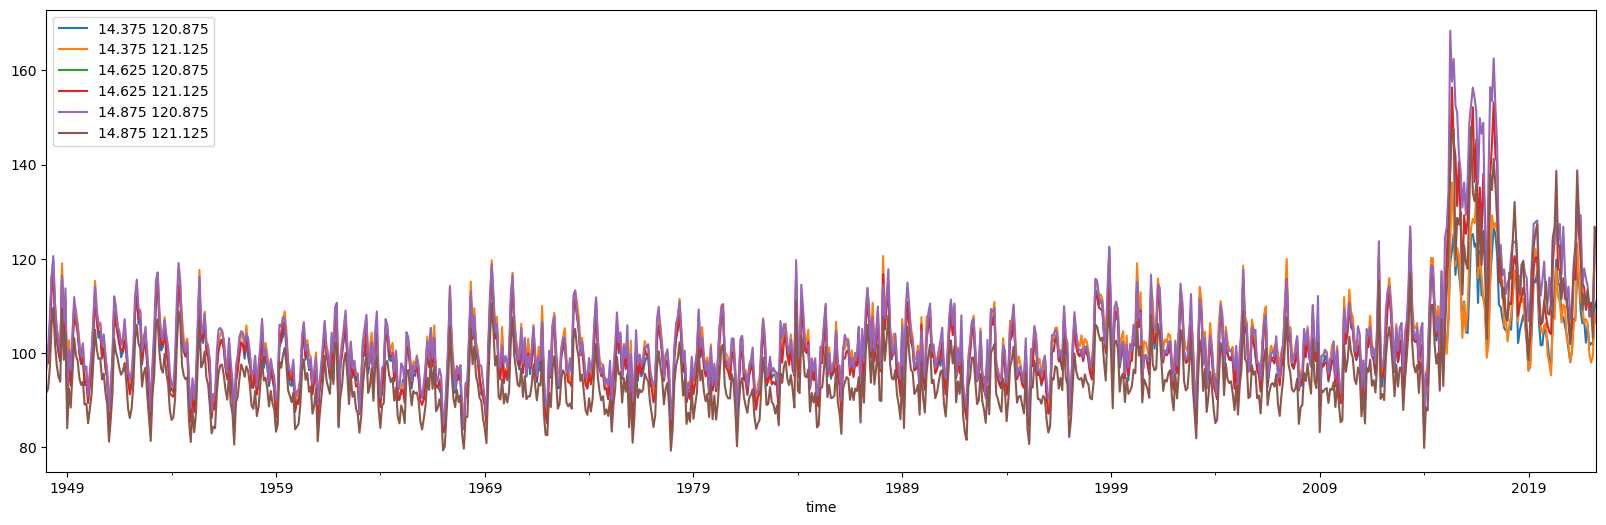

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6))

df = manila_hi.groupby([pd.Grouper(key='time', freq='M'), 'lat', 'lon']).max().reset_index()
#df = df.groupby(['time', 'lat', 'lon']).mean().reset_index()

for lat in [14.375, 14.625, 14.875]:
    for lon in [120.875, 121.125]:
        df1 = df[(df['lat']==lat)&(df['lon']==lon)]
        df1.plot(x='time', y='heat_index', label = str(lat)+' '+(str(lon)), ax=ax)

In [104]:
#DAVAO.explore()

<Axes: xlabel='time'>

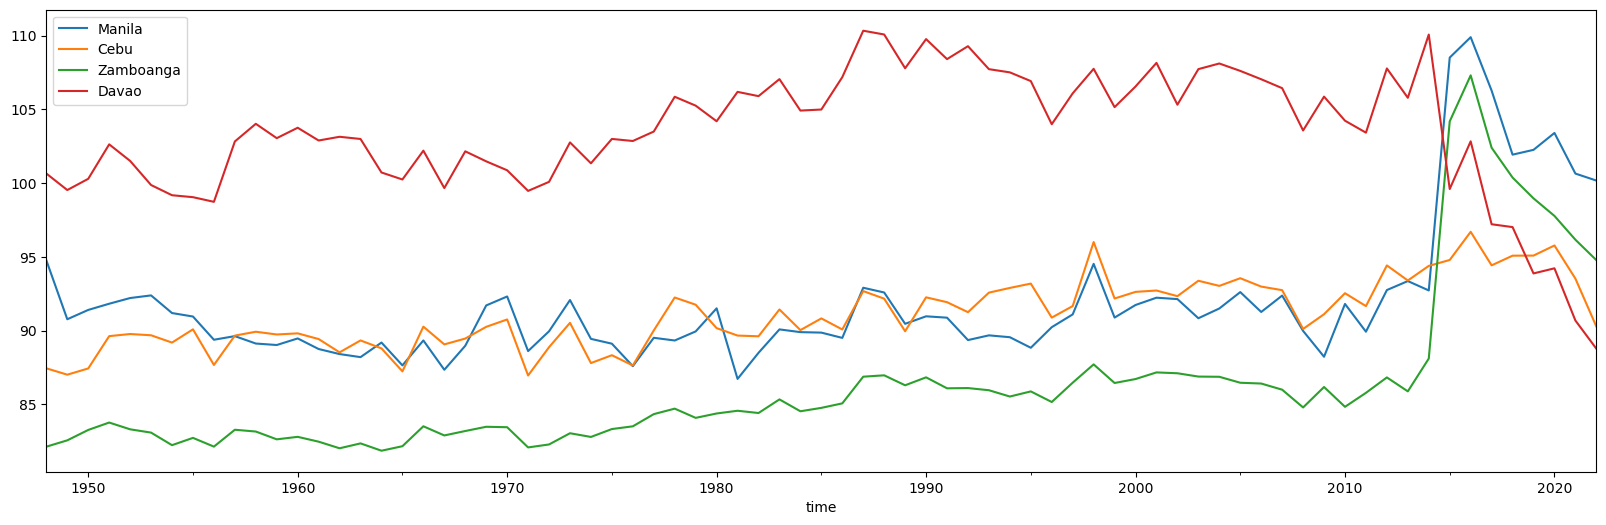

In [111]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,6))

df1 = manila_hi.groupby([pd.Grouper(key='time', freq='Y')]).mean().reset_index()
df2 = cebu_hi.groupby([pd.Grouper(key='time', freq='Y')]).mean().reset_index()
#df = df.groupby(['time', 'lat', 'lon']).mean().reset_index()

df1.plot(x='time', y='heat_index', label = 'Manila', ax=ax)
df2.plot(x='time', y='heat_index', label = 'Cebu', ax=ax)
zamboanga_hi.groupby([pd.Grouper(key='time', freq='Y')]).mean().reset_index().plot(x='time', y='heat_index', label = 'Zamboanga', ax=ax)
davao_hi.groupby([pd.Grouper(key='time', freq='Y')]).mean().reset_index().plot(x='time', y='heat_index', label = 'Davao', ax=ax)